<a href="https://colab.research.google.com/github/imran9891/TensorFlow/blob/main/06_transfer_learning_in_tensor_flow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 3: Scaling up (Food Vision Mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of Food).

Our goal is to beat the original Food101 paper with 10% of the training data (leveraging the power of deep learning).

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is 50.76% accuracy across 101 classes.


In [1]:
# Check to see if we're using a GPU?
!nvidia-smi

Tue Aug 10 15:45:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we've created a series of helper functions to do different tasks, let's download them.

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-08-10 15:45:34--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-10 15:45:34 (87.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the imge_data_modification notebook.

In [4]:
# Downloading the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

# Unzip the data
unzip_data("101_food_classes_10_percent.zip")

--2021-08-10 15:45:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 2607:f8b0:400e:c08::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  78.4MB/s    in 11s     

2021-08-10 15:45:51 (142 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# Setup directories
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [6]:
# How many images, classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/apple_pie'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/crab_cakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cannoli'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/deviled_eggs'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hot_dog'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pad_thai'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheesecake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '101_food_classe

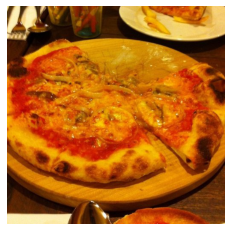

In [7]:
# Visualizing random images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
random_class = random.choice(os.listdir(train_dir))
img_path = train_dir + random_class
random_img = random.choice(os.listdir(img_path))
img = img_path + "/" + random_img
img = mpimg.imread(img)
plt.imshow(img)
plt.axis(False);

In [8]:
# Set up data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                                image_size=IMG_SIZE,
                                                                                batch_size=BATCH_SIZE,
                                                                                label_mode="categorical")
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE,
                                                                label_mode="categorical",
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 Food Classes

Here are the steps we're going to take:

* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature Extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to  save epoch time)

In [9]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         monitor='val_accuracy',
                                                         save_weights_only=True,
                                                         save_best_only=True)

In [13]:
# Create data augmentation layer to incorporate it right into our model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = tf.keras.models.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
],name="data_augmentation")

In [18]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = tf.keras.layers.Input(shape = (224,224,3), name = "input_layer")

# Passing through data augmentation layer
x = data_augmentation(inputs) # augment images (only happens during training phase)

# Passing into the base model
x = base_model(x, training = False) # put the base model in inference mode so weights which need to stay frozen, stays frozen

# Passing through Pooling layer
x = tf.keras.layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)

# Create the outputs
outputs = tf.keras.layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs,outputs)

In [19]:
# Get a summary of the model we've created
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_layer (Globa (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [20]:
# Compile the model

model.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [21]:
# Fit the model
history_0 = model.fit(train_data_all_10_percent,
                      epochs=5,
                      steps_per_epoch = len(train_data_all_10_percent),
                      validation_data = test_data,
                      validation_steps = int(0.15 * len(test_data)),
                      callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 124s 374ms/step - loss: 3.4873 - accuracy: 0.2424 - val_loss: 2.5807 - val_accuracy: 0.4258
Epoch 2/5
237/237 [==============================] - 70s 296ms/step - loss: 2.3741 - accuracy: 0.4569 - val_loss: 2.2516 - val_accuracy: 0.4611
Epoch 3/5
237/237 [==============================] - 64s 270ms/step - loss: 2.0033 - accuracy: 0.5261 - val_loss: 2.0704 - val_accuracy: 0.4783
Epoch 4/5
237/237 [==============================] - 61s 257ms/step - loss: 1.7788 - accuracy: 0.5655 - val_loss: 1.9831 - val_accuracy: 0.4881
Epoch 5/5
237/237 [==============================] - 58s 245ms/step - loss: 1.6415 - accuracy: 0.5938 - val_loss: 1.9274 - val_accuracy: 0.4963


In [22]:
# Evaluate on the full test data
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 88s 111ms/step - loss: 1.7310 - accuracy: 0.5479


[1.7309679985046387, 0.5479207634925842]

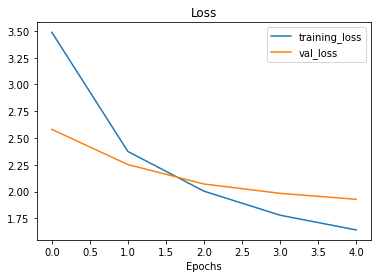

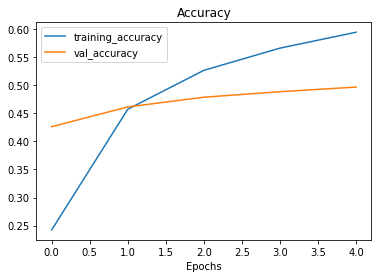

In [23]:
# Plotting loss curves
plot_loss_curves(history_0)

**Question:** What do these curves suggest? 
Hint: Ideally, the two curves should be very similar to each other, if not it may suggest that our model is overfitting (performing too well on the training data and not generalizing to unseen data).

## Fine Tuning

In [27]:
# Unfreeze all of the layers in base model
base_model.trainable = True

# Re-freeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [31]:
# Recompile model with lower learning rate (it's typically best practice to lower the learning rate when fine-tuning)
model.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lowered by 10x
    metrics=["accuracy"]
)

In [32]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [33]:
# Check which layers in our base model is trainable?
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)


0 input_5 False
1 rescaling_4 False
2 normalization_4 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [35]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has done already 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 = 10)

# Fine-tune our model
history_1 = model.fit(train_data_all_10_percent,
                      epochs = fine_tune_epochs,
                      validation_data = test_data,
                      validation_steps = int(0.15 * len(test_data)),
                      initial_epoch = history_0.epoch[-1])

Epoch 5/10
237/237 [==============================] - 66s 249ms/step - loss: 1.3807 - accuracy: 0.6478 - val_loss: 1.9392 - val_accuracy: 0.4992
Epoch 6/10
237/237 [==============================] - 58s 245ms/step - loss: 1.2874 - accuracy: 0.6607 - val_loss: 1.8797 - val_accuracy: 0.5175
Epoch 7/10
237/237 [==============================] - 56s 233ms/step - loss: 1.1971 - accuracy: 0.6813 - val_loss: 1.8908 - val_accuracy: 0.5162
Epoch 8/10
237/237 [==============================] - 51s 215ms/step - loss: 1.1361 - accuracy: 0.7003 - val_loss: 1.8413 - val_accuracy: 0.5265
Epoch 9/10
237/237 [==============================] - 52s 218ms/step - loss: 1.0650 - accuracy: 0.7164 - val_loss: 1.9013 - val_accuracy: 0.5135
Epoch 10/10
237/237 [==============================] - 51s 216ms/step - loss: 1.0157 - accuracy: 0.7296 - val_loss: 1.9014 - val_accuracy: 0.5151


In [36]:
# Evaluate on the whole test data
fine_tune_results = model.evaluate(test_data)
fine_tune_results

790/790 [==============================] - 88s 112ms/step - loss: 1.6160 - accuracy: 0.5736


[1.6159744262695312, 0.5735841393470764]

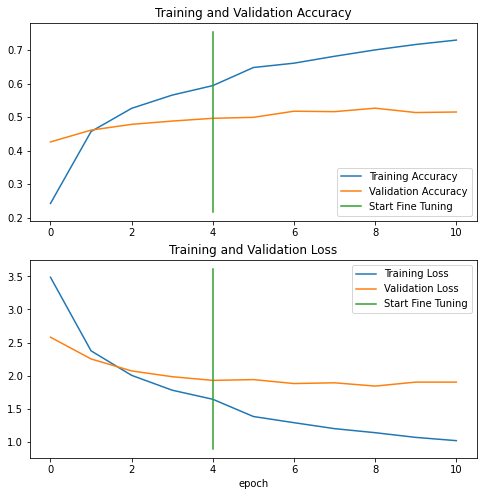

In [37]:
# Compare the histories of feature extraction model with fine tuning model
compare_historys(original_history=history_0, new_history=history_1, initial_epochs=5)